In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow import keras
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

#First 3 classes
class_mask = np.isin(y_train, [0, 1, 2])

x_train, y_train = x_train[class_mask], y_train[class_mask]
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
#Task 1 (VAE)
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2,
padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]
    z_size = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch_size, z_size))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2,
padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2,
padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid",
padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()
    self.reconstruction_loss_tracker = keras.metrics.Mean(
    name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

  @property
  def metrics(self):
    return [self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]
  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var = self.encoder(data)
      z = self.sampler(z_mean, z_log_var)
      reconstruction = decoder(z)
      reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
          keras.losses.binary_crossentropy(data, reconstruction),
          axis=(1, 2) ))
      kl_loss=-0.5*(1+z_log_var-tf.square(z_mean)-tf.exp(z_log_var))
      total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "total_loss": self.total_loss_tracker.result(),
        "reconstruction_loss":self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result() }

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

mnist_digits = np.concatenate([x_train, x_test], axis=0)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=20, batch_size=128)

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 73s 131ms/step - kl_loss: 1.1161 - reconstruction_loss: 265.1994 - total_loss: 266.3154
Epoch 2/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 79s 129ms/step - kl_loss: 2.5069 - reconstruction_loss: 183.1060 - total_loss: 185.6128
Epoch 3/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 72s 132ms/step - kl_loss: 3.8260 - reconstruction_loss: 163.5705 - total_loss: 167.3965
Epoch 4/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - kl_loss: 3.9246 - reconstruction_loss: 158.7092 - total_loss: 162.6339
Epoch 5/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 131ms/step - kl_loss: 3.9855 - reconstruction_loss: 155.8247 - total_loss: 159.8102
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - kl_loss: 3.9686 - reconstruction_loss: 154.4490 - total_loss: 158.4177
Epoch 7/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 80s 129ms/step - kl_loss: 3.9767 - reconstruction_loss: 152.7042 - total_loss: 156.6809
Epoch 8/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 84s 133ms/step - kl_loss: 3.9411 - reconstruction_loss: 151.9530

In [8]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):
    z_sample = np.array([[xi, yi]])
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[
      i * digit_size : (i + 1) * digit_size,
      j * digit_size : (j + 1) * digit_size,
    ] = digit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

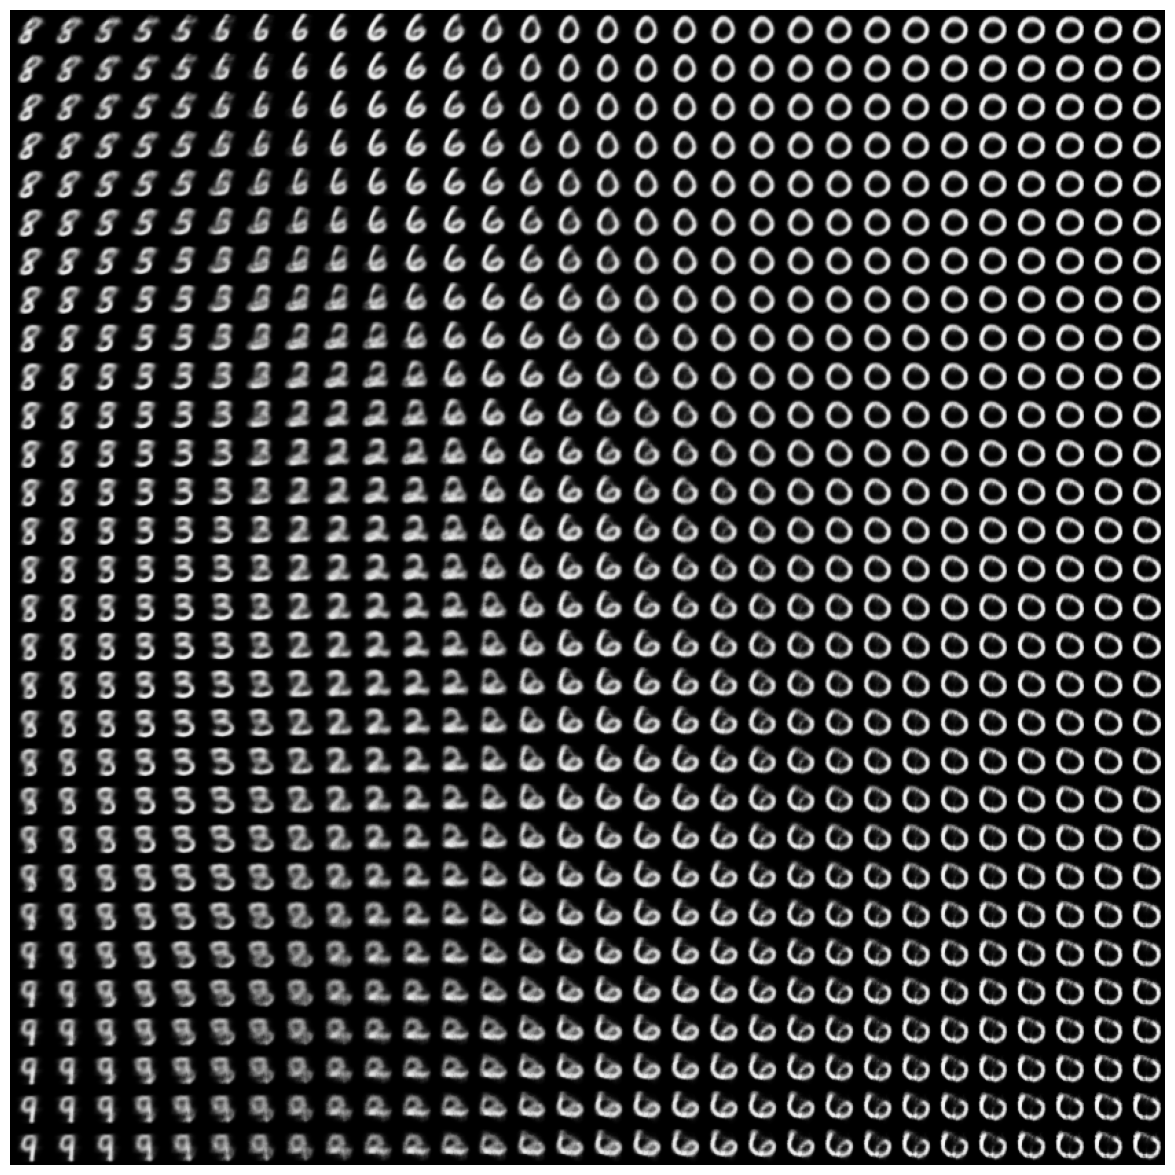

In [9]:
plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

Our results look very nice.

kl_loss: 3.7390 - reconstruction_loss: 146.8572 - total_loss: 150.5962
Our loss function is minimized around 3.74 which is very good.

From the figure, we can see the model is doing its job well.

In [10]:
#Task 2 (GAN)
# Discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [11]:
latent_dim = 2

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 64, activation="relu"),
        layers.Reshape((7, 7, 64)),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [14]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        real_images = tf.cast(real_images, dtype=tf.float32)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [15]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(x_train, epochs=20, batch_size=128)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - d_loss: 0.3602 - g_loss: 1.2270
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - d_loss: 0.1871 - g_loss: 2.0523
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - d_loss: 0.2264 - g_loss: 2.2516
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - d_loss: 0.4855 - g_loss: 1.3598
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - d_loss: 0.4352 - g_loss: 1.3647
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - d_loss: 0.4689 - g_loss: 1.2698
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - d_loss: 0.3994 - g_loss: 1.3908
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - d_loss: 0.4027 - g_loss: 1.7038
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - d_loss: 0.4444 - g_loss: 1.4231
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - d_loss: 0.4174 - g_loss: 1.4024
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - d_loss: 0.3481 - g_loss: 1.6112
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


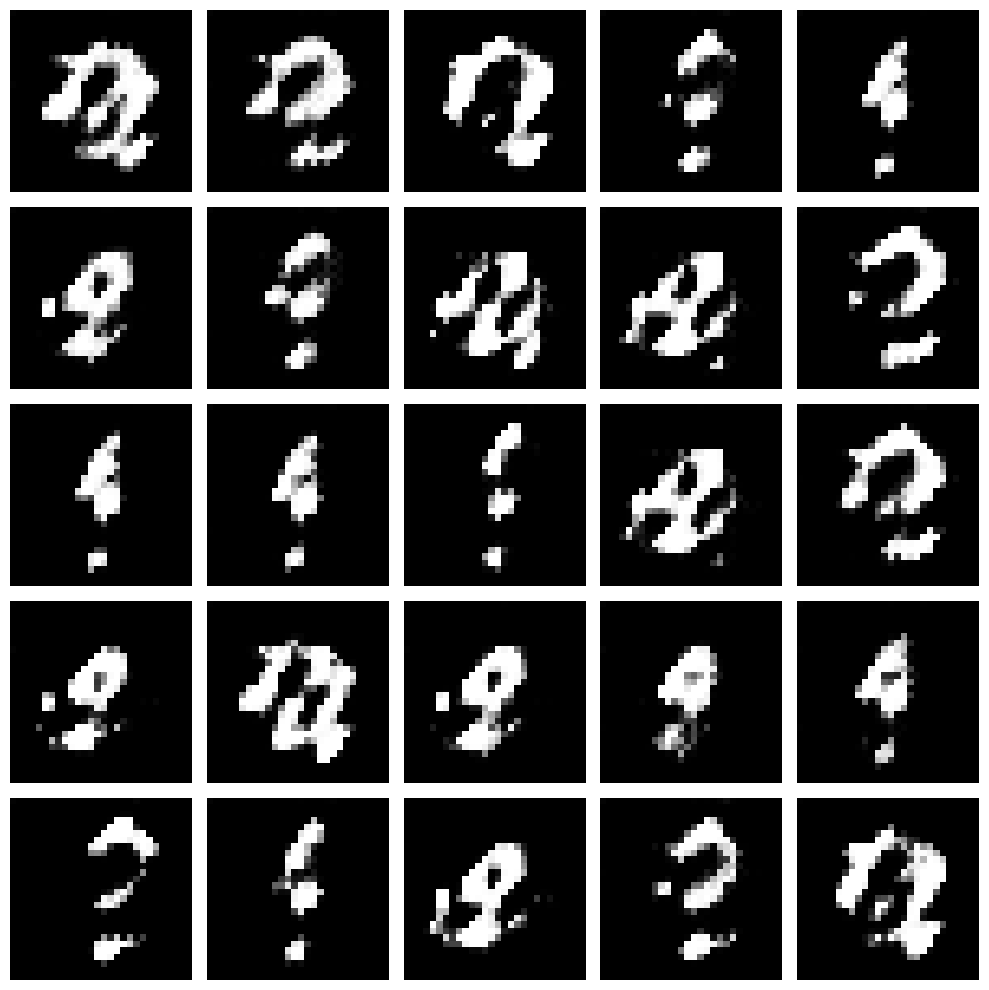

In [17]:
#Visualizing GAN

def plot_generated_images(generator, latent_dim, n=5):
    random_latent_vectors = tf.random.normal(shape=(n * n, latent_dim))
    generated_images = generator.predict(random_latent_vectors)

    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = generated_images[i, :, :, 0]
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_generated_images(generator, latent_dim=latent_dim)


Despite having a lower loss
d_loss: 0.4052 - g_loss: 1.4681

We see visually that the model does worse than VAE. However, VAE took significantly longer to train.